# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(-0.5, std_mod_reduc=0.15, std_damping=0.30)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
        pystrata.output.MaxAccelProfile(),
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

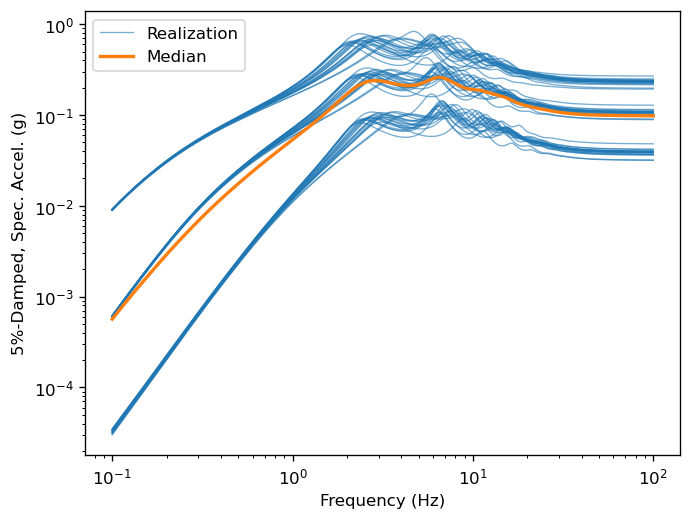

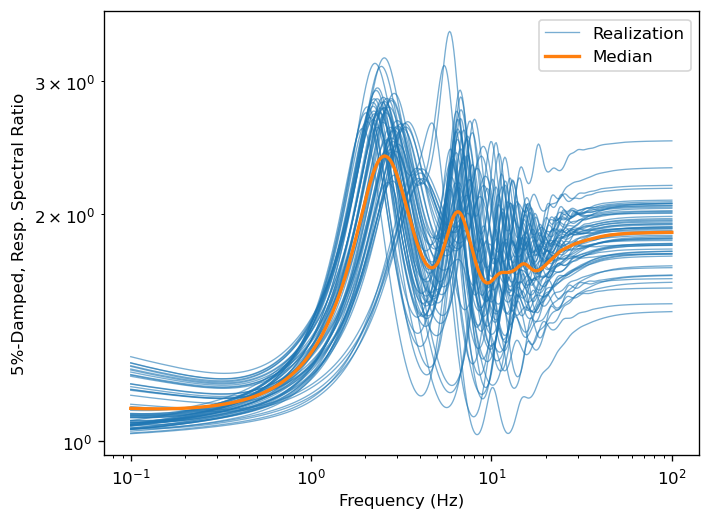

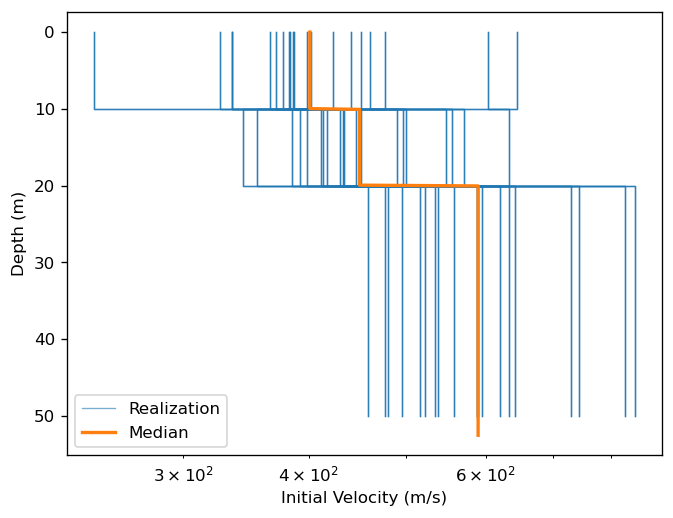

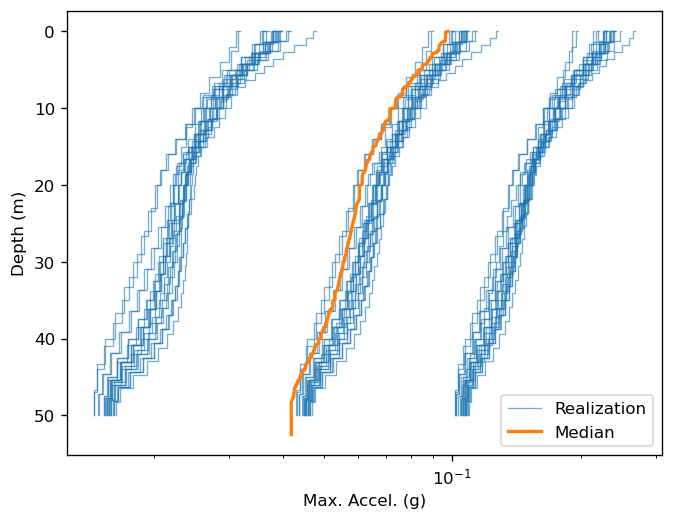

In [9]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [10]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.242271  1.080117  1.049824  1.223245  1.074396  1.046270   
0.101394    1.241372  1.080046  1.050204  1.222441  1.074335  1.046626   
0.102807    1.240476  1.079981  1.050589  1.221640  1.074279  1.046986   
0.104240    1.239584  1.079921  1.050977  1.220842  1.074228  1.047350   
0.105693    1.238695  1.079867  1.051370  1.220048  1.074184  1.047717   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.049471  1.941903  1.784594  2.007876  1.909623  1.771619   
95.932095   2.049545  1.941980  1.784692  2.007944  1.909691  1.771708   
97.269336   2.049617  1.942053  1.784786  2.008011  1.909757  1.771794   
98.625218   2.049686  1.942125  1.784878  2.008075  1.909822  1.771877   
100.000000  2.049753  1.942194  1.784967  2.008138  1.909884  1.771958   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.270002  1.087881  1.054372  1.170154  ...  1.051113  1.119095   
0.101394    1.268948  1.087795  1.054784  1.169638  ...  1.051502  1.118793   
0.102807    1.267896  1.087715  1.055200  1.169123  ...  1.051896  1.118491   
0.104240    1.266848  1.087641  1.055621  1.168611  ...  1.052293  1.118191   
0.105693    1.265804  1.087573  1.056046  1.168100  ...  1.052695  1.117892   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.984267  1.884215  1.706498  1.934389  ...  1.865636  2.003373   
95.932095   1.984351  1.884305  1.706607  1.934463  ...  1.865739  2.003392   
97.269336   1.984431  1.884392  1.706713  1.934534  ...  1.865838  2.003410   
98.625218   1.984510  1.884476  1.706816  1.934604  ...  1.865934  2.003427   
100.000000  1.984586  1.884557  1.706915  1.934671  ...  1.866028  2.003444   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.040777  1.025133  1.180784  1.060963  1.037692  1.225242   
0.101394    1.040767  1.025337  1.180179  1.060923  1.037988  1.224466   
0.102807    1.040759  1.025544  1.179576  1.060887  1.038287  1.223692   
0.104240    1.040756  1.025753  1.178975  1.060856  1.038589  1.222921   
0.105693    1.040756  1.025964  1.178377  1.060830  1.038894  1.222154   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.898995  1.843949  1.872613  1.796418  1.697054  2.180964   
95.932095   1.899002  1.843972  1.872671  1.796471  1.697122  2.181039   
97.269336   1.899008  1.843995  1.872727  1.796521  1.697188  2.181111   
98.625218   1.899014  1.844017  1.872781  1.796570  1.697252  2.181181   
100.000000  1.899020  1.844038  1.872834  1.796618  1.697315  2.181249   

                                
                  m1        m2  
0.100000    1.076201  1.048250  
0.101394    1.076140  1.048619  
0.102807    1.076083  1.048993  
0.104240    1.076032  1.049369  
0.105693    1.075987  1.049750  
...              ...       ...  
94.613238   2.061876  1.921678  
95.932095   2.061949  1.921778  
97.269336   2.062019  1.921875  
98.625218   2.062087  1.921968  
100.000000  2.062153  1.922059  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [11]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.melt(ignore_index=False).reset_index().set_index(["freq", "profile", "motion"])
df

,,,value
freq,profile,motion,
0.100000,p0,m0,1.242271
0.101394,p0,m0,1.241372
0.102807,p0,m0,1.240476
0.104240,p0,m0,1.239584
0.105693,p0,m0,1.238695
...,...,...,...
94.613238,p19,m2,1.921678
95.932095,p19,m2,1.921778
97.269336,p19,m2,1.921875


In [12]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(level=["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.208474  0.041692
           m1      1.070007  0.014888
           m2      1.043832  0.009872
0.101394   m0      1.207750  0.041515
           m1      1.069952  0.014865
...                     ...       ...
98.625218  m1      1.902535  0.076288
           m2      1.774737  0.072094
100.000000 m0      2.000398  0.087533
           m1      1.902595  0.076288
           m2      1.774816  0.072092

[1500 rows x 2 columns]

In [13]:
stats = (
    stats.reset_index("motion").pivot(columns="motion").swaplevel(0, 1, axis=1).sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.041692  1.208474  0.014888  1.070007  0.009872  1.043832
0.101394    0.041515  1.207750  0.014865  1.069952  0.009938  1.044169
0.102807    0.041338  1.207029  0.014843  1.069902  0.010004  1.044510
0.104240    0.041162  1.206310  0.014822  1.069857  0.010072  1.044854
0.105693    0.040986  1.205594  0.014801  1.069818  0.010139  1.045202
...              ...       ...       ...       ...       ...       ...
94.613238   0.087540  2.000136  0.076289  1.902344  0.072101  1.774485
95.932095   0.087538  2.000204  0.076288  1.902410  0.072099  1.774571
97.269336   0.087536  2.000271  0.076288  1.902474  0.072097  1.774655
98.625218   0.087534  2.000335  0.076288  1.902535  0.072094  1.774737
100.000000  0.087533  2.000398  0.076288  1.902595  0.072092  1.774816

[500 rows x 6 columns]

Access the properties of each motion like:

In [14]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.041692,1.208474
0.101394,0.041515,1.207750
0.102807,0.041338,1.207029
0.104240,0.041162,1.206310
0.105693,0.040986,1.205594
...,...,...
94.613238,0.087540,2.000136
95.932095,0.087538,2.000204
97.269336,0.087536,2.000271


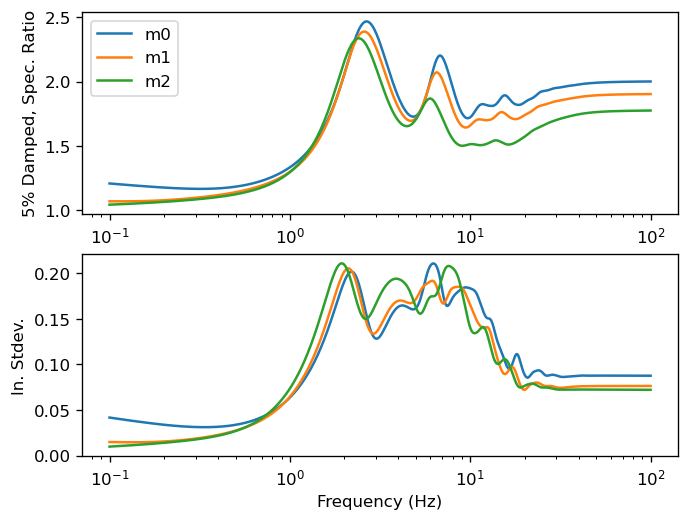

In [15]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.T.groupby(level=0):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.columns, g.loc[name, key], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;